# Building a Structured Data Extraction and LLM - Query Pipeline from complex Excel Files with LlamaIndex

# Introduction

This notebook is designed to extract structured shipment data from Excel files that contain multiple sheets. Each sheet represents a shipment, which consists of multiple packages, and each package contains multiple items.

Due to the hierarchical structure and complexity of the Excel format, including nested cells, simple Pandas-based extraction is insufficient. To address this, we employ a structured approach using Pydantic models (`Shipment`, `Package`, `Item`) to represent the data in a hierarchical manner. The process involves:

1. **Reading the Excel file** using Pandas and converting its contents into LlamaIndex’s Document format.

2. **Extracting structured data** by leveraging an LLM to parse the documents and populate the Pydantic models.

3. **Storing the structured data** in a SQL database since the extracted data is too large for direct querying with an LLM.

4. **Retrieving relevant data** using LlamaIndex's `NLSQLRetriever`, which translates natural language queries into SQL statements executed against the database. This enables efficient, context-aware query resolution.

5. **Formatting the retrieved data** into a Pandas DataFrame and exporting it back to an Excel file for further analysis or reporting.

This pipeline enables scalable and efficient structured data extraction, storage, and retrieval, making it possible to interact with complex shipment data using natural language queries.

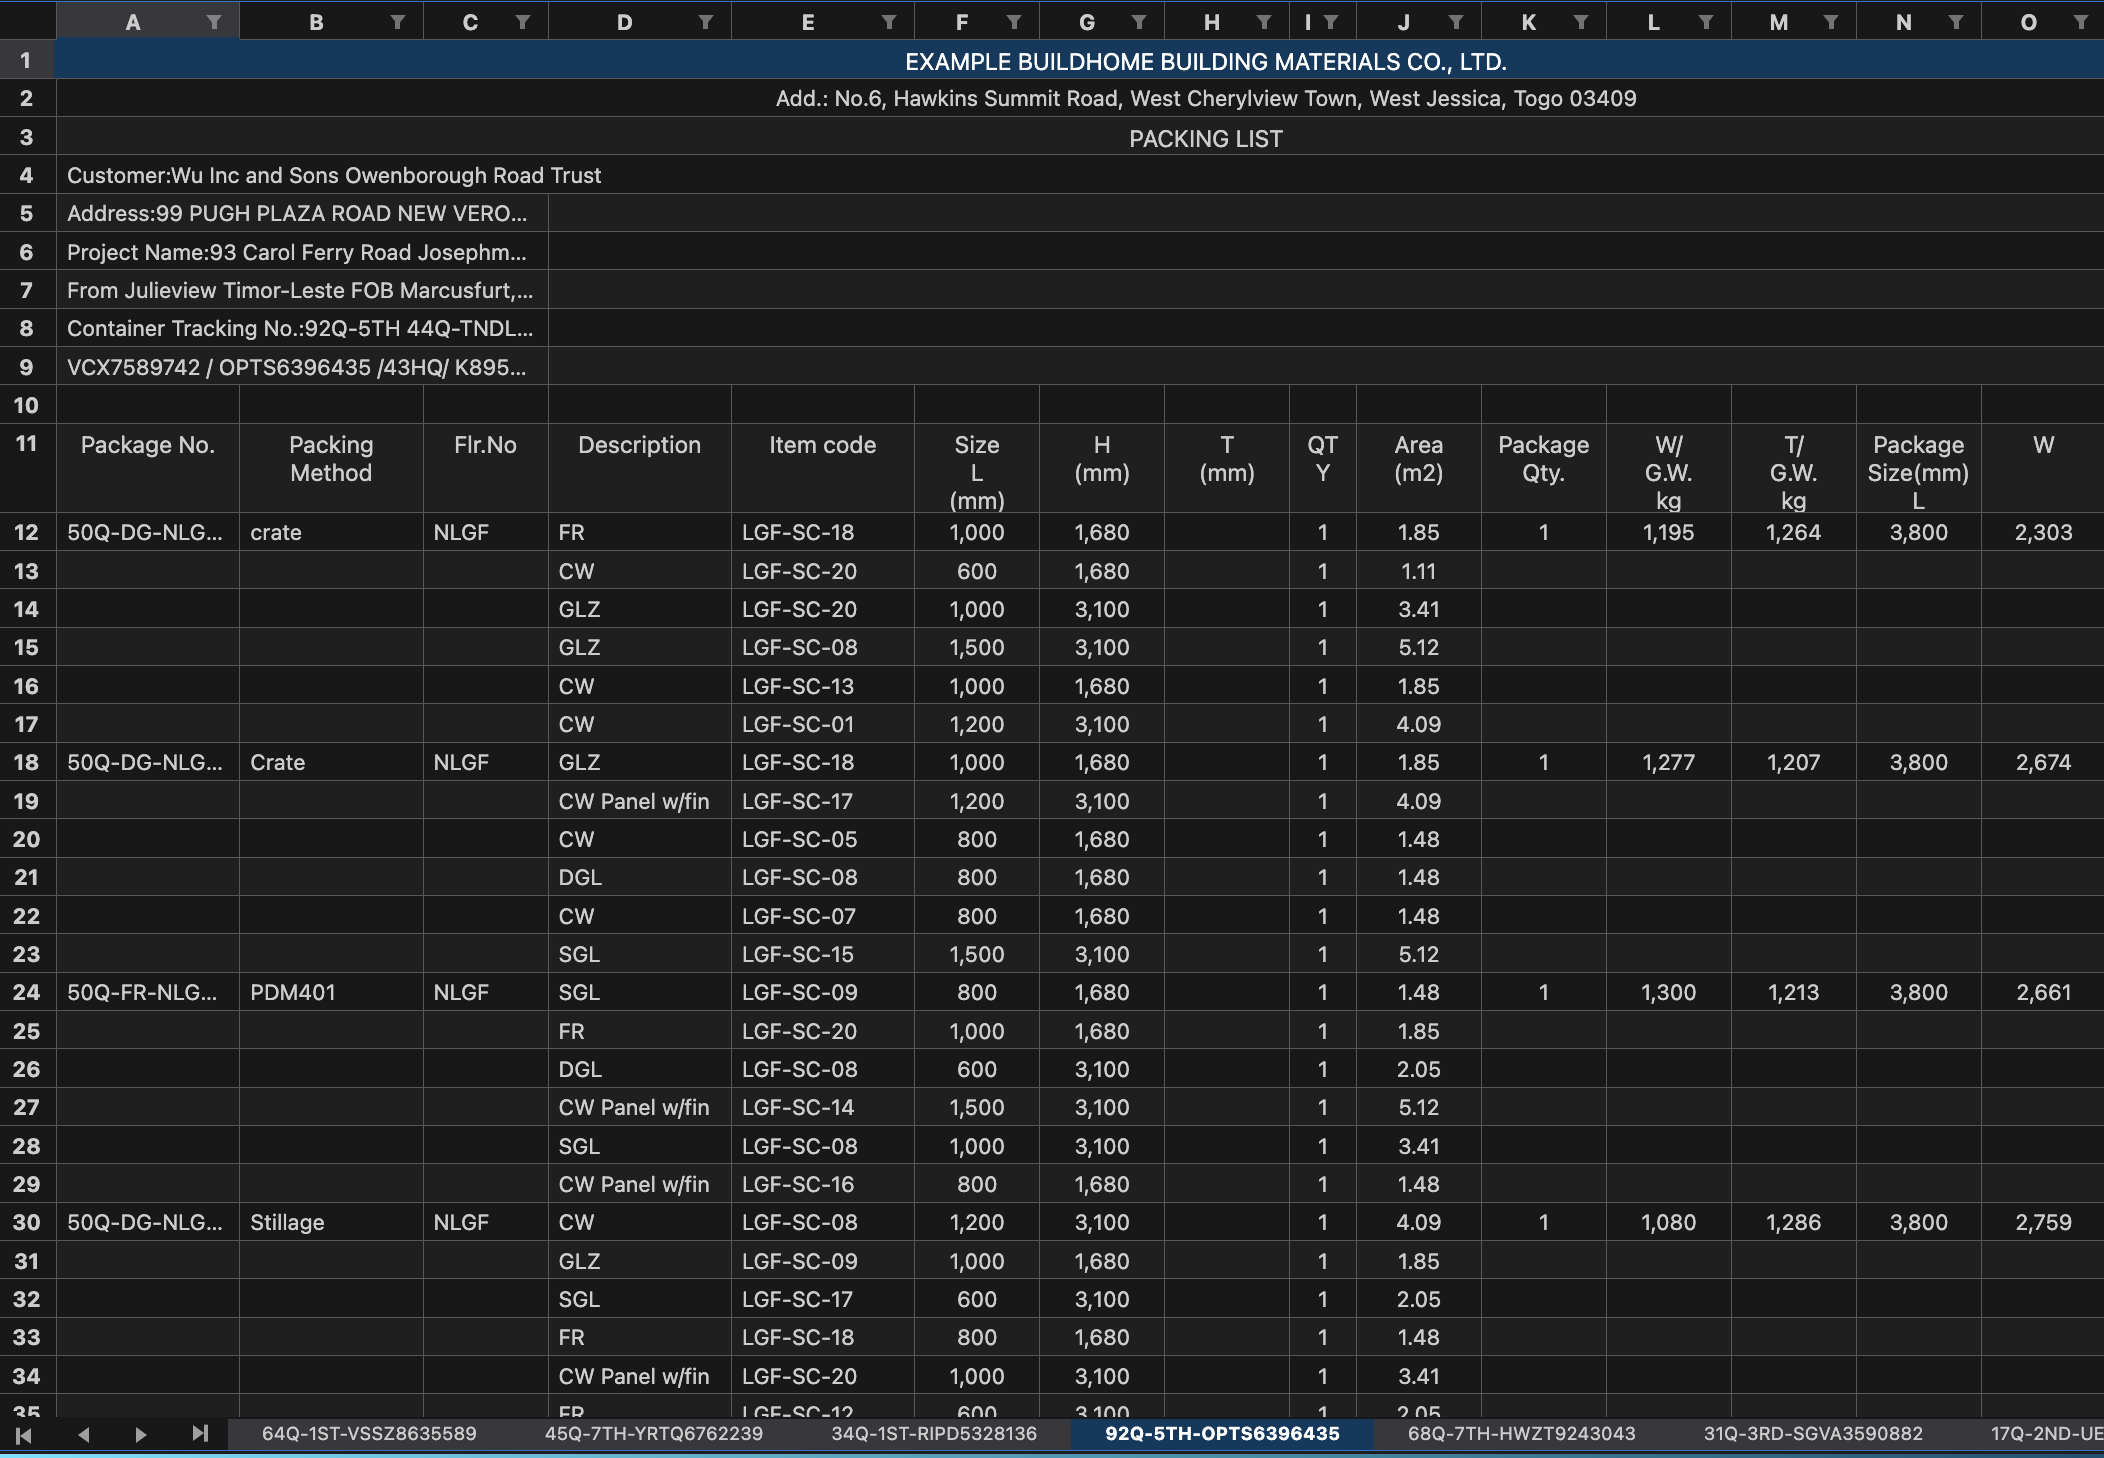

In [32]:
from IPython.display import Image, display

# Display the example file
display(Image(filename='./data/example_file.png'))


# Importing libraries 

In [1]:
%pip install -qU pydantic llama-index llama-index-llms-openai llama-index-core sqlalchemy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Setting up llm

In [ ]:
from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-4o-mini")

# #example
# llm.complete("What is the capital of France?")

# Data Exploration

You can see how complex the excel file is by looking at the first 20 rows of the data.  

In [2]:
import pandas as pd
df = pd.read_excel("./data/synthetic_data.xlsx")
print(df.head(20))


       EXAMPLE BUILDHOME BUILDING MATERIALS CO., LTD.      Unnamed: 1  \
0   Add.: No.23, Martin Falls Road, East Benjamin ...             NaN   
1                                        PACKING LIST             NaN   
2   Customer:Acosta, Sparks and Robinson LLC New R...             NaN   
3   Address:46 SARAH FLATS ROAD PORT ANDREWVIEW PR...             NaN   
4     Project Name:64 Christopher Pike Road Jamesbury             NaN   
5   From Michelleville South Georgia and the South...             NaN   
6   Container Tracking No.:64Q-1ST 56Q-SKVN2312 Sh...             NaN   
7   XTE4382668 / VSSZ8635589 /42HQ/ F2799618 /4PAC...             NaN   
8                                                 NaN             NaN   
9                                         Package No.  Packing Method   
10                                    50Q-FR-NLGF-15B          PDM401   
11                                                NaN             NaN   
12                                                N

# Defining schemas

Here we define the schemas for the data we are going to extract from the excel files.

These models will guide the LLM to extract the data in a structured manner.

In [35]:
from pydantic import BaseModel, Field
from typing import Optional

"""LLMs are using JSON schemas from Pydantic as instructions on how to return data. 
To assist them and improve the accuracy of your returned data, it’s helpful to include natural-language descriptions of objects and fields and what they’re used for. 
Pydantic has support for this with docstrings and Fields."""

class Item(BaseModel):
    """A model that represents an item"""
    item_code: str = Field(..., description="Unique identifier code for the item")
    #size: ItemSize = Field(..., description="Physical dimensions of the item")
    des: str = Field(..., description="Description of the item, appearing before each Item Code")


class PackageItem(BaseModel):
    """A model that represents an item in a package with its quantity"""
    item: Item = Field(..., description="The item")
    quantity: int = Field(..., description="Quantity of this item in the package")

class Package(BaseModel):
    """A model that represents a package"""
    package_code: str = Field(..., description="Unique identifier code for the package")
    packing_method: Optional[str] = Field(..., description="Type of packaging used e.g Stillage, Box, ...")
    floor_number: str = Field(..., description="Floor number where the package will be used, located in the 'Flr.no' col for each package")
    items: list[PackageItem] = Field(..., description="Items in the package and their quantity")
  

class Shipment(BaseModel):
    """A model that represents a shipment"""
    shipment_id: str = Field(..., description="Unique identifier for the shipment, appearing after the first'/' in the row below the row containing 'Container Tracking No.'. Also appears after the second '-' in file name.")
    container_tracking_number: str = Field(..., description="Tracking number for the shipping container")
    package_code: list[str] = Field(..., description="List of package codes included in this shipment")
    ETA: str = Field(..., description="Estimated time of arrival for the shipment")
    arrival_status: str = Field(..., description="Current status of the shipment's arrival")
    packages: list[Package] = Field(..., description="List of packages in the shipment")


# Convert excel file into LlamaIndex's Documents

Use pandas to read excel files and convert them into LlamaIndex's Documents, making it easier for the LLM to parse the data.

In [6]:
import pandas as pd
from llama_index.core import Document

documents = []
def parse_excel_file(file_path, exclude_sheets=None):
    """
    Parse all sheets from an Excel file, excluding specified sheets, and combine the data.
    Maintains the original parsing instructions and output structure.
    
    :param file_path: Path to the Excel file to parse.
    :param exclude_sheets: Optional list of sheet names to exclude from parsing.
    :return: Combined parsed data from all sheets (e.g., a DataFrame or structured output as per original script).
    """
    if exclude_sheets is None:
        exclude_sheets = []
    
    # Load the Excel file and get all sheet names
    xls = pd.ExcelFile(file_path)
    
    for sheet_name in xls.sheet_names:
        # Skip this sheet if it's in the exclusion list
        if sheet_name in exclude_sheets:
            continue
        
        # Read the current sheet into a DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        # Clean the DataFrame
        df = df.dropna(axis=1, how='all') # drop cols with NaN, only drop if ALL values in that row/column are NaN or empty.
        df = df.dropna(axis=0, how='all') # drop rows with NaN, only drop if ALL values in that row/column are NaN or empty.
        df = df.fillna("") # fill NaN with empty string execpt packaging method fill

        #remove col 5th till 13th to avoid redundant data
        df = df.drop(df.columns[[*range(5, 13), *range(14, len(df.columns))]], axis=1)
     
        # Append the parsed result for this sheet to our list
        markdown_content = df.to_markdown()
        # Create Document with sheet metadata
        doc = Document(
            text=markdown_content,
            metadata={"sheet_name": sheet_name}
        )
        documents.append(doc)
    
    return documents
    

# Example usage:
file_path = "data/synthetic_data.xlsx"
exclude = ["Summary"]  # sheets to exclude (if any)
docs = parse_excel_file(file_path, exclude_sheets=exclude)

# Print first document content and metadata as an example
data = "\n\n".join([
    f"=== New Sheet: {d.metadata.get('sheet_name', 'New Sheet below')} ===\n{d.get_content(metadata_mode='all')}" 
    for d in docs[0:]
])


In [7]:
print(docs[0].get_content(metadata_mode="all"))

sheet_name: 64Q-1ST-VSSZ8635589

|    | EXAMPLE BUILDHOME BUILDING MATERIALS CO., LTD.                                                     | Unnamed: 1     | Unnamed: 2   | Unnamed: 3            | Unnamed: 4   | Unnamed: 13      |
|---:|:---------------------------------------------------------------------------------------------------|:---------------|:-------------|:----------------------|:-------------|:-----------------|
|  0 | Add.: No.23, Martin Falls Road, East Benjamin Town, Salazarmouth, Ireland 41345                    |                |              |                       |              |                  |
|  1 | PACKING LIST                                                                                       |                |              |                       |              |                  |
|  2 | Customer:Acosta, Sparks and Robinson LLC New Roberto Road Trust                                    |                |              |                       |            

In [8]:
print(len(docs))

7


In [9]:
print(data)

=== New Sheet: 64Q-1ST-VSSZ8635589 ===
sheet_name: 64Q-1ST-VSSZ8635589

|    | EXAMPLE BUILDHOME BUILDING MATERIALS CO., LTD.                                                     | Unnamed: 1     | Unnamed: 2   | Unnamed: 3            | Unnamed: 4   | Unnamed: 13      |
|---:|:---------------------------------------------------------------------------------------------------|:---------------|:-------------|:----------------------|:-------------|:-----------------|
|  0 | Add.: No.23, Martin Falls Road, East Benjamin Town, Salazarmouth, Ireland 41345                    |                |              |                       |              |                  |
|  1 | PACKING LIST                                                                                       |                |              |                       |              |                  |
|  2 | Customer:Acosta, Sparks and Robinson LLC New Roberto Road Trust                                    |                |            

# Iterate through Documents and extract Shipments

Here we define the prompt for the llm to extract Shipments from the excel files.

In [10]:
import json
from llama_index.core.prompts import ChatPromptTemplate

SHIPMENT_EXTRACT_PROMPT = """\
You are given shipment data below. Extract shipment details from each sheet into the defined schema.
The shipment id appears after the first '/' in the row below the row containing 'Container Tracking No.' and also appears after the second '-' in file name.
- An **item is always listed in the same row or in rows directly below** its package's row, until another package row appears.
- Items **continue belonging to the package** until another **Package No. row appears**.

IMPORTANT: For each item in packages, you must return a complete Item object with:
    1. item_code: The code string (like 'LGF01-SC-16')
    3. des: A description string for the item

    For example, instead of just 'LGF01-SC-16', return:
    {
        "item_code": "LGF01-SC-16",
        "des": "CW"
    }

    Make sure every PackageItem contains a complete Item object, not just the item code string.

If there is no information for a field, leave it blank! You can skip packages with missing Packing method.

{data}
"""

prompt = ChatPromptTemplate.from_messages([
    ("user", SHIPMENT_EXTRACT_PROMPT)
])

print(prompt)
shipments = []
for i in range(len(docs)):
    shipment_extraction = await llm.astructured_predict(
        Shipment,
        prompt,
        data="\n".join([docs[i].get_content(metadata_mode="all")])
    )
    shipments.append(shipment_extraction)



metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['data'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None message_templates=[ChatMessage(role=<MessageRole.USER: 'user'>, additional_kwargs={}, blocks=[TextBlock(block_type='text', text='You are given shipment data below. Extract shipment details from each sheet into the defined schema.\nThe shipment id appears after the first \'/\' in the row below the row containing \'Container Tracking No.\' and also appears after the second \'-\' in file name.\n- An **item is always listed in the same row or in rows directly below** its package\'s row, until another package row appears.\n- Items **continue belonging to the package** until another **Package No. row appears**.\n\nIMPORTANT: For each item in packages, you must return a complete Item object with:\n    1. item_code: The code string (like \'LGF01-SC-16\')\n    3. des: A description string for the item\n\n    For example, instead of just \'

In [11]:
print(len(shipments))

for shipment in shipments:
    json_output = shipment.model_dump_json()
    print(json.dumps(json.loads(json_output), indent=2))


7
{
  "shipment_id": "VSSZ8635589",
  "container_tracking_number": "64Q-1ST 56Q-SKVN2312",
  "package_code": [
    "50Q-FR-NLGF-15B",
    "50Q-FR-NLGF-06T",
    "50Q-DG-LG-13B",
    "50Q-CW-L02-08T"
  ],
  "ETA": "JAN.21.2026",
  "arrival_status": "",
  "packages": [
    {
      "package_code": "50Q-FR-NLGF-15B",
      "packing_method": "PDM401",
      "floor_number": "NLGF",
      "items": [
        {
          "item": {
            "item_code": "LGF-SC-17",
            "des": "FR"
          },
          "quantity": 1
        },
        {
          "item": {
            "item_code": "LGF-SC-20",
            "des": "FR"
          },
          "quantity": 1
        },
        {
          "item": {
            "item_code": "LGF-SC-11",
            "des": "CW"
          },
          "quantity": 1
        },
        {
          "item": {
            "item_code": "LGF-SC-04",
            "des": "CW"
          },
          "quantity": 1
        },
        {
          "item": {
            "i

# Convert Shipment to JSON and save to file

This allows us to save the data to a file and load it back later.

In [48]:
# Convert shipments to JSON and save to file
import json

# Convert Pydantic models to dict first
shipments_json = [shipment.model_dump() for shipment in shipments]

# Save to JSON file with pretty printing
with open('data/shipments.json', 'w', encoding='utf-8') as f:
    json.dump(shipments_json, f, indent=2, ensure_ascii=False)

# Explanation
You can see that the Pydantic models assited the LLM to extract the data in a structured manner.

However, the resulting data is still deeply nested and does not conform to a relational schema directly.

SQL requires clear relationships between tables (e.g., Shipments, Packages, Items):

        Specifically, the packages list inside shipment and the items list inside each package are not directly insertable into SQL tables.
    
        Flattening them into DataFrames enables clear many-to-one and many-to-many relationships.

Thus we need to convert the data into DataFrames as an intermediary step before inserting into SQL.

# Load data into ShipmentDatabase


Use the ShipmentDatabase class to manage the shipment data by converting the data into DataFrames which make it easier to populate into SQL database.

In [49]:
from typing import List
import pandas as pd
import json

class ShipmentDatabase:
    """
    A database class for managing shipment data with filtering, sorting, 
    aggregation, and Excel export capabilities.
    Uses Pydantic models for data validation and structure.
    """
    
    def __init__(self, shipments: List[Shipment] = None):
        """Initialize the database with shipments or an empty list"""
        self.shipments = shipments or []
        self.df_shipments = None
        self.df_packages = None
        self.df_items = None
        
        # If shipments are provided, convert to DataFrames immediately
        if self.shipments:
            self._convert_to_dataframes()
    
    def add_shipment(self, shipment: Shipment):
        """Add a single shipment to the database"""
        self.shipments.append(shipment)
        # Refresh dataframes
        self._convert_to_dataframes()
    
    def add_shipments(self, shipments: List[Shipment]):
        """Add multiple shipments to the database"""
        self.shipments.extend(shipments)
        # Refresh dataframes
        self._convert_to_dataframes()
    
    def _convert_to_dataframes(self):
        """Convert shipment objects to pandas DataFrames for analysis"""
        # Shipment level DataFrame
        shipment_records = []
        package_records = []
        item_records = []
        
        for shipment in self.shipments:
            # Convert Pydantic model to dict using model_dump instead of dict
            # shipment_dict = shipment.model_dump()
            
            # Add shipment record
            shipment_record = {
                'shipment_id': shipment.shipment_id,
                'container_tracking_number': shipment.container_tracking_number,
                'ETA': shipment.ETA,
                'arrival_status': shipment.arrival_status,
                'package_count': len(shipment.packages)
            }
            shipment_records.append(shipment_record)
            
            # Process packages and items
            for package in shipment.packages:
                package_dict = {
                    'shipment_id': shipment.shipment_id,
                    'package_code': package.package_code,
                    'packing_method': package.packing_method or "",
                    'floor_number': package.floor_number,
                    'item_count': len(package.items)
                }
                package_records.append(package_dict)
                
                # Process items in package
                for package_item in package.items:
                    item_dict = {
                        'shipment_id': shipment.shipment_id,
                        'package_code': package.package_code,
                        'item_code': package_item.item.item_code,
                        'description': package_item.item.des,
                        'quantity': package_item.quantity,
                        'floor_number': package.floor_number
                    }
                    item_records.append(item_dict)
        
        # Create DataFrames
        self.df_shipments = pd.DataFrame(shipment_records)
        self.df_packages = pd.DataFrame(package_records)
        self.df_items = pd.DataFrame(item_records)
    
    # Serialization/deserialization
    def save_to_json(self, filename='data/shipment_database.json'):
        """Save the database to a JSON file"""
        # Use model_dump instead of dict
        serialized = [shipment.model_dump() for shipment in self.shipments]
            
        with open(filename, 'w') as f:
            json.dump(serialized, f, indent=2)
        
        print(f"Database saved to {filename}")
    
    @classmethod
    def load_from_json(cls, filename='data/shipment_database.json'):
        """Load a database from a JSON file"""
        with open(filename, 'r') as f:
            data = json.load(f)
        
        # Convert the dictionaries back to Pydantic models
        # Each shipment_dict is transformed into an instance of the Shipment class.
        shipments = [Shipment.model_validate(shipment_dict) for shipment_dict in data]
        
        return cls(shipments)
    
    @classmethod
    def from_llm_json(cls, json_data):
        """Create a ShipmentDatabase from a list of JSON data extracted by an LLM"""
        # Ensure json_data is a list
        if isinstance(json_data, str):
            # If json_data is a string, parse it
            json_data = json.loads(json_data)
        
        if not isinstance(json_data, list):
            raise ValueError("Input data must be a list of JSON objects.")
        
        # Convert each JSON object in the list to a Shipment object
        shipments = []
        for shipment_dict in json_data:
            shipment = Shipment.model_validate(shipment_dict)
            shipments.append(shipment)
        
        # Create and return a new ShipmentDatabase with these shipments
        return cls(shipments)

## load from json file

In [50]:
import os

json_file_path = "data/shipments.json"  # Change this to your actual path
    
# Check if the file exists
if not os.path.exists(json_file_path):
    print(f"Error: File '{json_file_path}' not found.")


print(f"Loading shipment data from {json_file_path}...")

# Load the database from JSON
try:
    db = ShipmentDatabase.load_from_json(json_file_path)
    print(f"Successfully loaded data with {len(db.shipments)} shipments.")

except Exception as e:
    print(f"Error loading data: {str(e)}")


Loading shipment data from data/shipments.json...
Successfully loaded data with 7 shipments.


In [51]:
db.df_shipments

,shipment_id,container_tracking_number,ETA,arrival_status,package_count
0,VSSZ8635589,64Q-1ST 56Q-SKVN2312,JAN.21.2026,,4
1,YRTQ6762239,45Q-7TH 30Q-HPNH9196,JAN.2.2026,,5
2,RIPD5328136,34Q-1ST 51Q-OTHL9657,JAN.1.2026,,5
3,OPTS6396435,92Q-5TH 44Q-TNDL4162,JAN.11.2026,,6
4,HWZT9243043,68Q-7TH,JAN.23.2026,,6
5,SGVA3590882,31Q-3RD 72Q-KRVU0599,JAN.17.2026,,4
6,UESI5659579,17Q-2ND 89Q-WLDH1551,JAN.22.2026,,5


## load directly from the Shipment list extracted by the LLM





In [53]:
db_from_json = ShipmentDatabase.from_llm_json(shipments_json)
# print out the db
db_from_json.df_shipments


,shipment_id,container_tracking_number,ETA,arrival_status,package_count
0,VSSZ8635589,64Q-1ST 56Q-SKVN2312,JAN.21.2026,,4
1,YRTQ6762239,45Q-7TH 30Q-HPNH9196,JAN.2.2026,,5
2,RIPD5328136,34Q-1ST 51Q-OTHL9657,JAN.1.2026,,5
3,OPTS6396435,92Q-5TH 44Q-TNDL4162,JAN.11.2026,,6
4,HWZT9243043,68Q-7TH,JAN.23.2026,,6
5,SGVA3590882,31Q-3RD 72Q-KRVU0599,JAN.17.2026,,4
6,UESI5659579,17Q-2ND 89Q-WLDH1551,JAN.22.2026,,5


# Create SQL database with ORM 

Here we load the dataframesinto a SQL database using SQLAlchemy ORM.

In [16]:
import sqlalchemy
from sqlalchemy import create_engine, Column, String, Integer, ForeignKey, UniqueConstraint, text, PrimaryKeyConstraint
from sqlalchemy.orm import declarative_base, relationship
import os
import pandas as pd

# Define ORM models at module level
Base = declarative_base()

class Shipment(Base):
    __tablename__ = 'shipments'
    
    shipment_id = Column(String, primary_key=True)
    container_tracking_number = Column(String, nullable=False)
    ETA = Column(String, nullable=False)
    arrival_status = Column(String, nullable=False)
    package_count = Column(Integer)
    
    # Relationships
    packages = relationship("Package", back_populates="shipment")

class Package(Base):
    __tablename__ = 'packages'
    
    package_code = Column(String, nullable=False)
    shipment_id = Column(String, ForeignKey('shipments.shipment_id'), nullable=False)
    packing_method = Column(String)
    floor_number = Column(String)
    item_count = Column(Integer)
    
    # Relationships
    shipment = relationship("Shipment", back_populates="packages")
    items = relationship("Item", back_populates="package")
    
    # Define composite primary key
    __table_args__ = (
        PrimaryKeyConstraint('shipment_id', 'package_code'),
    )

class Item(Base):
    __tablename__ = 'items'
    id = Column(Integer, primary_key=True, autoincrement=True)  # Auto-generated ID
    item_code = Column(String, nullable=False)
    package_code = Column(String, ForeignKey('packages.package_code'), nullable=False)
    shipment_id = Column(String, ForeignKey('shipments.shipment_id'), nullable=False)
    description = Column(String)
    quantity = Column(Integer, nullable=True)
    floor_number = Column(String)
    
    # Relationships
    package = relationship("Package", back_populates="items")


def create_db_with_orm(shipments_db, db_name="data/shipment_sql_alchemy.db"):
    """
    Create a SQLite database from a ShipmentDatabase instance using SQLAlchemy ORM
    """
    print(f"Creating database '{db_name}' from shipment data with ORM...")
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(db_name), exist_ok=True)
    
    try:
        # Delete existing database file if it exists
        if os.path.exists(db_name):
            os.remove(db_name)
            print(f"Removed existing database at {db_name}")
        
        # Create SQLAlchemy engine
        engine = create_engine(f"sqlite:///{db_name}")
        
        # Create tables
        Base.metadata.create_all(engine)
        
        # Populate tables with data
        with engine.connect() as conn:
            if hasattr(shipments_db, 'df_shipments') and shipments_db.df_shipments is not None:
                shipments_db.df_shipments.to_sql('shipments', conn, if_exists='append', index=False)
                print(f"Populated 'shipments' table with {len(shipments_db.df_shipments)} rows")
            
            if hasattr(shipments_db, 'df_packages') and shipments_db.df_packages is not None:
                shipments_db.df_packages.to_sql('packages', conn, if_exists='append', index=False)
                print(f"Populated 'packages' table with {len(shipments_db.df_packages)} rows")
            
            if hasattr(shipments_db, 'df_items') and shipments_db.df_items is not None:
                shipments_db.df_items.to_sql('items', conn, if_exists='append', index=False)
                print(f"Populated 'items' table with {len(shipments_db.df_items)} rows")
                
            # Create views
            conn.execute(text("""
            CREATE VIEW IF NOT EXISTS vw_item_details AS
            SELECT 
                i.item_code,
                i.description,
                i.quantity,
                i.package_code,
                p.packing_method,
                p.floor_number,
                i.shipment_id,
                s.container_tracking_number,
                s.ETA,
                s.arrival_status
            FROM 
                items i
            LEFT JOIN 
                packages p ON i.shipment_id = p.shipment_id AND i.package_code = p.package_code
            LEFT JOIN 
                shipments s ON i.shipment_id = s.shipment_id
            """))
            
            conn.commit()
            
        print(f"Database saved to: {os.path.abspath(db_name)}")
        return engine
        
    except Exception as e:
        print(f"Error creating database from shipment data: {str(e)}")
        return None

In [17]:
# Create the database
engine = create_db_with_orm(db)

Creating database 'data/shipment_sql_alchemy.db' from shipment data with ORM...
Removed existing database at data/shipment_sql_alchemy.db
Populated 'shipments' table with 7 rows
Populated 'packages' table with 35 rows
Populated 'items' table with 166 rows
Database saved to: /Users/dangphuonganh/Documents/newEo/Echat/data/shipment_sql_alchemy.db


In [18]:
from sqlalchemy import create_engine, inspect
with engine.connect() as conn:
    # Get inspector
    inspector = inspect(engine)

    # Get table information
    columns = inspector.get_columns("shipments")
    print("Table schema:")
    for column in columns:
        print(column)

Table schema:
{'name': 'shipment_id', 'type': VARCHAR(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'container_tracking_number', 'type': VARCHAR(), 'nullable': False, 'default': None, 'primary_key': 0}
{'name': 'ETA', 'type': VARCHAR(), 'nullable': False, 'default': None, 'primary_key': 0}
{'name': 'arrival_status', 'type': VARCHAR(), 'nullable': False, 'default': None, 'primary_key': 0}
{'name': 'package_count', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}


# Part 1: Text-to-SQL Query Engine

https://docs.llamaindex.ai/en/stable/examples/index_structs/struct_indices/SQLIndexDemo/#part-1-text-to-sql-query-engine

## Create sql database

In [19]:
from llama_index.core import SQLDatabase
from sqlalchemy import create_engine, MetaData

# # Create the database
# engine = create_db_with_orm(db)

if engine is not None:
    # Load metadata
    metadata_obj = MetaData()
    metadata_obj.create_all(engine)
    
    # Connect to LlamaIndex
    sql_database = SQLDatabase(engine, include_tables=["shipments", "packages", "items"])
else:
    print("Failed to create database engine. Cannot proceed.")

In [20]:
from IPython.display import Markdown, display

We can use the NLSQLTableQueryEngine to construct natural language queries that are synthesized into SQL queries.

Note that we **need to specify the tables we want to use** with this query engine. If we don't the query engine will pull all the schema context, which could overflow the context window of the LLM.

This approach can be very time consuming if the database is large.

In [21]:
from llama_index.core.query_engine import NLSQLTableQueryEngine

query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database, tables=["items"], llm=llm
)
query_str = "List all rows where floor number is NLGF?"
response = query_engine.query(query_str)
print(response)

The following items are located on the floor number NLGF:

1. ID: 1, Item Code: LGF-SC-17, Description: FR, Quantity: 1
2. ID: 2, Item Code: LGF-SC-20, Description: FR, Quantity: 1
3. ID: 3, Item Code: LGF-SC-11, Description: CW, Quantity: 1
4. ID: 4, Item Code: LGF-SC-04, Description: CW, Quantity: 1
5. ID: 5, Item Code: LGF-SC-06, Description: GLZ, Quantity: 1
6. ID: 6, Item Code: LGF-SC-14, Description: SGL, Quantity: 1
7. ID: 7, Item Code: LGF-SC-09, Description: GLZ, Quantity: 1
8. ID: 8, Item Code: LGF-SC-02, Description: CW, Quantity: 1
9. ID: 9, Item Code: LGF-SC-02, Description: SGL, Quantity: 1
10. ID: 10, Item Code: LGF-SC-18, Description: GLZ, Quantity: 1
11. ID: 11, Item Code: LGF-SC-04, Description: GLZ, Quantity: 1
12. ID: 20, Item Code: LGF-SC-02, Description: CW, Quantity: 1
13. ID: 21, Item Code: LGF-SC-19, Description: GLZ, Quantity: 1
14. ID: 22, Item Code: LGF-SC-08, Description: CW, Quantity: 1
15. ID: 23, Item Code: LGF-SC-13, Description: CW, Quantity: 1
16. ID:

In [22]:
display(Markdown(f"<b>{response}</b>"))

<b>The following items are located on the floor number NLGF:

1. ID: 1, Item Code: LGF-SC-17, Description: FR, Quantity: 1
2. ID: 2, Item Code: LGF-SC-20, Description: FR, Quantity: 1
3. ID: 3, Item Code: LGF-SC-11, Description: CW, Quantity: 1
4. ID: 4, Item Code: LGF-SC-04, Description: CW, Quantity: 1
5. ID: 5, Item Code: LGF-SC-06, Description: GLZ, Quantity: 1
6. ID: 6, Item Code: LGF-SC-14, Description: SGL, Quantity: 1
7. ID: 7, Item Code: LGF-SC-09, Description: GLZ, Quantity: 1
8. ID: 8, Item Code: LGF-SC-02, Description: CW, Quantity: 1
9. ID: 9, Item Code: LGF-SC-02, Description: SGL, Quantity: 1
10. ID: 10, Item Code: LGF-SC-18, Description: GLZ, Quantity: 1
11. ID: 11, Item Code: LGF-SC-04, Description: GLZ, Quantity: 1
12. ID: 20, Item Code: LGF-SC-02, Description: CW, Quantity: 1
13. ID: 21, Item Code: LGF-SC-19, Description: GLZ, Quantity: 1
14. ID: 22, Item Code: LGF-SC-08, Description: CW, Quantity: 1
15. ID: 23, Item Code: LGF-SC-13, Description: CW, Quantity: 1
16. ID: 24, Item Code: LGF-SC-11, Description: GLZ, Quantity: 1
17. ID: 25, Item Code: LGF-SC-20, Description: GLZ, Quantity: 1
18. ID: 26, Item Code: LGF-SC-03, Description: SGL, Quantity: 1
19. ID: 27, Item Code: LGF-SC-19, Description: CW, Quantity: 1
20. ID: 28, Item Code: LGF-SC-07, Description: CW Panel w/fin, Quantity: 1
21. ID: 29, Item Code: LGF-SC-20, Description: SGL, Quantity: 1
22. ID: 30, Item Code: LGF-SC-03, Description: SGL, Quantity: 1
23. ID: 31, Item Code: LGF-SC-18, Description: FR, Quantity: 1
24. ID: 32, Item Code: LGF-SC-02, Description: FR, Quantity: 1
25. ID: 33, Item Code: LGF-SC-10, Description: SGL, Quantity: 1
26. ID: 34, Item Code: LGF-SC-18, Description: FR, Quantity: 1
27. ID: 35, Item Code: LGF-SC-17, Description: SGL, Quantity: 1
28. ID: 36, Item Code: LGF-SC-04, Description: CW Panel w/fin, Quantity: 1
29. ID: 45, Item Code: LGF-SC-09, Description: CW, Quantity: 1
30. ID: 46, Item Code: LGF-SC-05, Description: CW, Quantity: 1
31. ID: 47, Item Code: LGF-SC-03, Description: CW Panel w/fin, Quantity: 1
32. ID: 48, Item Code: LGF-SC-02, Description: DGL, Quantity: 1
33. ID: 49, Item Code: LGF-SC-10, Description: CW, Quantity: 1
34. ID: 50, Item Code: LGF-SC-14, Description: CW Panel w/fin, Quantity: 1
35. ID: 51, Item Code: LGF-SC-12, Description: CW, Quantity: 1
36. ID: 52, Item Code: LGF-SC-18, Description: SGL, Quantity: 1
37. ID: 53, Item Code: LGF-SC-19, Description: DGL, Quantity: 1
38. ID: 54, Item Code: LGF-SC-20, Description: FR, Quantity: 1
39. ID: 55, Item Code: LGF-SC-20, Description: GLZ, Quantity: 1
40. ID: 56, Item Code: LGF-SC-14, Description: CW, Quantity: 1
41. ID: 57, Item Code: LGF-SC-07, Description: GLZ, Quantity: 1
42. ID: 58, Item Code: LGF-SC-19, Description: CW, Quantity: 1
43. ID: 59, Item Code: LGF-SC-12, Description: FR, Quantity: 1
44. ID: 60, Item Code: LGF-SC-05, Description: SGL, Quantity: 1
45. ID: 69, Item Code: LGF-SC-18, Description: FR, Quantity: 1
46. ID: 70, Item Code: LGF-SC-20, Description: CW, Quantity: 1
47. ID: 71, Item Code: LGF-SC-20, Description: GLZ, Quantity: 1
48. ID: 72, Item Code: LGF-SC-08, Description: GLZ, Quantity: 1
49. ID: 73, Item Code: LGF-SC-13, Description: CW, Quantity: 1
50. ID: 74, Item Code: LGF-SC-01, Description: CW, Quantity: 1
51. ID: 75, Item Code: LGF-SC-18, Description: GLZ, Quantity: 1
52. ID: 76, Item Code: LGF-SC-17, Description: CW Panel w/fin, Quantity: 1
53. ID: 77, Item Code: LGF-SC-05, Description: CW, Quantity: 1
54. ID: 78, Item Code: LGF-SC-08, Description: DGL, Quantity: 1
55. ID: 79, Item Code: LGF-SC-07, Description: CW, Quantity: 1
56. ID: 80, Item Code: LGF-SC-15, Description: SGL, Quantity: 1
57. ID: 81, Item Code: LGF-SC-09, Description: SGL, Quantity: 1
58. ID: 82, Item Code: LGF-SC-20, Description: FR, Quantity: 1
59. ID: 83, Item Code: LGF-SC-08, Description: DGL, Quantity: 1
60. ID: 84, Item Code: LGF-SC-14, Description: CW Panel w/fin, Quantity: 1
61. ID: 85, Item Code: LGF-SC-08, Description: SGL, Quantity: 1
62. ID: 86, Item Code: LGF-SC-16, Description: CW Panel w/fin, Quantity: 1
63. ID: 87, Item Code: LGF-SC-08, Description: CW, Quantity: 1
64. ID: 88, Item Code: LGF-SC-09, Description: GLZ, Quantity: 1
65. ID: 89, Item Code: LGF-SC-17, Description: SGL, Quantity: 1
66. ID: 90, Item Code: LGF-SC-18, Description: FR, Quantity: 1
67. ID: 91, Item Code: LGF-SC-20, Description: CW Panel w/fin, Quantity: 1
68. ID: 92, Item Code: LGF-SC-12, Description: FR, Quantity: 1
69. ID: 99, Item Code: LGF-SC-13, Description: GLZ, Quantity: 1
70. ID: 100, Item Code: LGF-SC-12, Description: GLZ, Quantity: 1
71. ID: 101, Item Code: LGF-SC-10, Description: FR, Quantity: 1
72. ID: 102, Item Code: LGF-SC-12, Description: GLZ, Quantity: 1
73. ID: 103, Item Code: LGF-SC-01, Description: CW Panel w/fin, Quantity: 1
74. ID: 104, Item Code: LGF-SC-07, Description: SGL, Quantity: 1
75. ID: 105, Item Code: LGF-SC-05, Description: DGL, Quantity: 1
76. ID: 106, Item Code: LGF-SC-12, Description: SGL, Quantity: 1
77. ID: 107, Item Code: LGF-SC-13, Description: CW Panel w/fin, Quantity: 1
78. ID: 108, Item Code: LGF-SC-07, Description: SGL, Quantity: 1
79. ID: 109, Item Code: LGF-SC-12, Description: FR, Quantity: 1
80. ID: 110, Item Code: LGF-SC-19, Description: GLZ, Quantity: 1
81. ID: 111, Item Code: LGF-SC-08, Description: DGL, Quantity: 1
82. ID: 112, Item Code: LGF-SC-04, Description: DGL, Quantity: 1
83. ID: 113, Item Code: LGF-SC-01, Description: SGL, Quantity: 1
84. ID: 114, Item Code: LGF-SC-19, Description: CW Panel w/fin, Quantity: 1
85. ID: 124, Item Code: LGF-SC-13, Description: FR, Quantity: 1
86. ID: 125, Item Code: LGF-SC-04, Description: GLZ, Quantity: 1
87. ID: 126, Item Code: LGF-SC-18, Description: SGL, Quantity: 1
88. ID: 127, Item Code: LGF-SC-14, Description: FR, Quantity: 1
89. ID: 128, Item Code: LGF-SC-11, Description: DGL, Quantity: 1
90. ID: 129, Item Code: LGF-SC-03, Description: CW, Quantity: 1
91. ID: 130, Item Code: LGF-SC-05, Description: CW Panel w/fin, Quantity: 1
92. ID: 131, Item Code: LGF-SC-15, Description: CW Panel w/fin, Quantity: 1
93. ID: 132, Item Code: LGF-SC-10, Description: DGL, Quantity: 1
94. ID: 133, Item Code: LGF-SC-02, Description: GLZ, Quantity: 1
95. ID: 143, Item Code: LGF-SC-11, Description: DGL, Quantity: 1
96. ID: 144, Item Code: LGF-SC-17, Description: CW Panel w/fin, Quantity: 1
97. ID: 145, Item Code: LGF-SC-06, Description: DGL, Quantity: 1
98. ID: 146, Item Code: LGF-SC-04, Description: CW, Quantity: 1
99. ID: 147, Item Code: LGF-SC-15, Description: GLZ, Quantity: 1
100. ID: 148, Item Code: LGF-SC-07, Description: FR, Quantity: 1
101. ID: 149, Item Code: LGF-SC-18, Description: DGL, Quantity: 1
102. ID: 150, Item Code: LGF-SC-17, Description: DGL, Quantity: 1
103. ID: 151, Item Code: LGF-SC-02, Description: SGL, Quantity: 1
104. ID: 152, Item Code: LGF-SC-14, Description: GLZ, Quantity: 1
105. ID: 153, Item Code: LGF-SC-01, Description: FR, Quantity: 1
106. ID: 154, Item Code: LGF-SC-09, Description: GLZ, Quantity: 1
107. ID: 155, Item Code: LGF-SC-13, Description: SGL, Quantity: 1
108. ID: 156, Item Code: LGF-SC-11, Description: SGL, Quantity: 1
109. ID: 157, Item Code: LGF-SC-13, Description: CW Panel w/fin, Quantity: 1
110. ID: 158, Item Code: LGF-SC-20, Description: DGL, Quantity: 1

This list includes all items associated with the specified floor number.</b>

This query engine should be used in any case where you can specify the tables you want to query over beforehand, or the total size of all the table schema plus the rest of the prompt fits your context window.

# Part 2: use SQL retriever on its own



Instead of using the NLSQLTableQueryEngine, we can use the NLSQLRetriever to retrieve the raw results from the database.

Sometimes the database is too big to be directly query using LLM. In this case, we can use the NLSQLRetriever to retrieve the raw results from the database and then format the results into a DataFrame. 

Doing this can yield results much faster than using the NLSQLTableQueryEngine and save prompting cost.

In [23]:
from llama_index.core.retrievers import NLSQLRetriever

# default retrieval (return_raw=True)
nl_sql_retriever = NLSQLRetriever(
    sql_database, tables=["shipments", "packages", "items"], return_raw=True, verbose=True
)


The following is the prompt used by the NLSQLRetriever to convert the natural language query to SQL query.

In [24]:
print(nl_sql_retriever._text_to_sql_prompt.template)

Given an input question, first create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Pay attention to which column is in which table. Also, qualify column names with the table name when needed. You are required to use the following format, each taking one line:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result of the SQLQuery
Answer: Final answer here

Only use tables listed below.
{schema}

Question: {query_str}
SQLQuery: 


In [25]:
results = nl_sql_retriever.retrieve(
    "return all rows in items table that belong to floor number NLGF"
)

> Table Info: Table 'shipments' has columns: shipment_id (VARCHAR), container_tracking_number (VARCHAR), ETA (VARCHAR), arrival_status (VARCHAR), package_count (INTEGER), .
> Table Info: Table 'packages' has columns: package_code (VARCHAR), shipment_id (VARCHAR), packing_method (VARCHAR), floor_number (VARCHAR), item_count (INTEGER),  and foreign keys: ['shipment_id'] -> shipments.['shipment_id'].
> Table Info: Table 'items' has columns: id (INTEGER), item_code (VARCHAR), package_code (VARCHAR), shipment_id (VARCHAR), description (VARCHAR), quantity (INTEGER), floor_number (VARCHAR),  and foreign keys: ['package_code'] -> packages.['package_code'], ['shipment_id'] -> shipments.['shipment_id'].
> Table desc str: Table 'shipments' has columns: shipment_id (VARCHAR), container_tracking_number (VARCHAR), ETA (VARCHAR), arrival_status (VARCHAR), package_count (INTEGER), .

Table 'packages' has columns: package_code (VARCHAR), shipment_id (VARCHAR), packing_method (VARCHAR), floor_number (VA

In [26]:
from llama_index.core.response.notebook_utils import display_source_node

# NOTE: all the content is in the metadata
for n in results:
    display_source_node(n, show_source_metadata=True)

**Node ID:** f28946e8-7b84-41b7-bbb6-62d4d663e297<br>**Similarity:** None<br>**Text:** [(1, 'LGF-SC-17', '50Q-FR-NLGF-15B', 'VSSZ8635589', 'FR', 1, 'NLGF'), (2, 'LGF-SC-20', '50Q-FR-NL...<br>**Metadata:** {'sql_query': "SELECT * \nFROM items\nWHERE floor_number = 'NLGF';", 'result': [(1, 'LGF-SC-17', '50Q-FR-NLGF-15B', 'VSSZ8635589', 'FR', 1, 'NLGF'), (2, 'LGF-SC-20', '50Q-FR-NLGF-15B', 'VSSZ8635589', 'FR', 1, 'NLGF'), (3, 'LGF-SC-11', '50Q-FR-NLGF-15B', 'VSSZ8635589', 'CW', 1, 'NLGF'), (4, 'LGF-SC-04', '50Q-FR-NLGF-15B', 'VSSZ8635589', 'CW', 1, 'NLGF'), (5, 'LGF-SC-06', '50Q-FR-NLGF-15B', 'VSSZ8635589', 'GLZ', 1, 'NLGF'), (6, 'LGF-SC-14', '50Q-FR-NLGF-06T', 'VSSZ8635589', 'SGL', 1, 'NLGF'), (7, 'LGF-SC-09', '50Q-FR-NLGF-06T', 'VSSZ8635589', 'GLZ', 1, 'NLGF'), (8, 'LGF-SC-02', '50Q-FR-NLGF-06T', 'VSSZ8635589', 'CW', 1, 'NLGF'), (9, 'LGF-SC-02', '50Q-FR-NLGF-06T', 'VSSZ8635589', 'SGL', 1, 'NLGF'), (10, 'LGF-SC-18', '50Q-FR-NLGF-06T', 'VSSZ8635589', 'GLZ', 1, 'NLGF'), (11, 'LGF-SC-04', '50Q-FR-NLGF-06T', 'VSSZ8635589', 'GLZ', 1, 'NLGF'), (20, 'LGF-SC-02', '50Q-GL-NLGF-09B', 'YRTQ6762239', 'CW', 1, 'NLGF'), (21, 'LGF-SC-19', '50Q-GL-NLGF-09B', 'YRTQ6762239', 'GLZ', 1, 'NLGF'), (22, 'LGF-SC-08', '50Q-GL-NLGF-09B', 'YRTQ6762239', 'CW', 1, 'NLGF'), (23, 'LGF-SC-13', '50Q-GL-NLGF-09B', 'YRTQ6762239', 'CW', 1, 'NLGF'), (24, 'LGF-SC-11', '50Q-GL-NLGF-09B', 'YRTQ6762239', 'GLZ', 1, 'NLGF'), (25, 'LGF-SC-20', '50Q-GL-NLGF-09B', 'YRTQ6762239', 'GLZ', 1, 'NLGF'), (26, 'LGF-SC-03', '50Q-CW-NLGF-05T', 'YRTQ6762239', 'SGL', 1, 'NLGF'), (27, 'LGF-SC-19', '50Q-CW-NLGF-05T', 'YRTQ6762239', 'CW', 1, 'NLGF'), (28, 'LGF-SC-07', '50Q-CW-NLGF-05T', 'YRTQ6762239', 'CW Panel w/fin', 1, 'NLGF'), (29, 'LGF-SC-20', '50Q-CW-NLGF-05T', 'YRTQ6762239', 'SGL', 1, 'NLGF'), (30, 'LGF-SC-03', '50Q-CW-NLGF-05T', 'YRTQ6762239', 'SGL', 1, 'NLGF'), (31, 'LGF-SC-18', '50Q-FR-NLGF-05T', 'YRTQ6762239', 'FR', 1, 'NLGF'), (32, 'LGF-SC-02', '50Q-FR-NLGF-05T', 'YRTQ6762239', 'FR', 1, 'NLGF'), (33, 'LGF-SC-10', '50Q-FR-NLGF-05T', 'YRTQ6762239', 'SGL', 1, 'NLGF'), (34, 'LGF-SC-18', '50Q-FR-NLGF-05T', 'YRTQ6762239', 'FR', 1, 'NLGF'), (35, 'LGF-SC-17', '50Q-FR-NLGF-05T', 'YRTQ6762239', 'SGL', 1, 'NLGF'), (36, 'LGF-SC-04', '50Q-FR-NLGF-05T', 'YRTQ6762239', 'CW Panel w/fin', 1, 'NLGF'), (45, 'LGF-SC-09', '50Q-DG-NLGF-01T', 'RIPD5328136', 'CW', 1, 'NLGF'), (46, 'LGF-SC-05', '50Q-DG-NLGF-01T', 'RIPD5328136', 'CW', 1, 'NLGF'), (47, 'LGF-SC-03', '50Q-DG-NLGF-01T', 'RIPD5328136', 'CW Panel w/fin', 1, 'NLGF'), (48, 'LGF-SC-02', '50Q-DG-NLGF-01T', 'RIPD5328136', 'DGL', 1, 'NLGF'), (49, 'LGF-SC-10', '50Q-DG-NLGF-01T', 'RIPD5328136', 'CW', 1, 'NLGF'), (50, 'LGF-SC-14', '50Q-DG-NLGF-01T', 'RIPD5328136', 'CW Panel w/fin', 1, 'NLGF'), (51, 'LGF-SC-12', '50Q-CW-NLGF-10B', 'RIPD5328136', 'CW', 1, 'NLGF'), (52, 'LGF-SC-18', '50Q-CW-NLGF-10B', 'RIPD5328136', 'SGL', 1, 'NLGF'), (53, 'LGF-SC-19', '50Q-CW-NLGF-10B', 'RIPD5328136', 'DGL', 1, 'NLGF'), (54, 'LGF-SC-20', '50Q-CW-NLGF-10B', 'RIPD5328136', 'FR', 1, 'NLGF'), (55, 'LGF-SC-20', '50Q-CW-NLGF-10B', 'RIPD5328136', 'GLZ', 1, 'NLGF'), (56, 'LGF-SC-14', '50Q-CW-NLGF-20T', 'RIPD5328136', 'CW', 1, 'NLGF'), (57, 'LGF-SC-07', '50Q-CW-NLGF-20T', 'RIPD5328136', 'GLZ', 1, 'NLGF'), (58, 'LGF-SC-19', '50Q-CW-NLGF-20T', 'RIPD5328136', 'CW', 1, 'NLGF'), (59, 'LGF-SC-12', '50Q-CW-NLGF-20T', 'RIPD5328136', 'FR', 1, 'NLGF'), (60, 'LGF-SC-05', '50Q-CW-NLGF-20T', 'RIPD5328136', 'SGL', 1, 'NLGF'), (69, 'LGF-SC-18', '50Q-DG-NLGF-12T', 'OPTS6396435', 'FR', 1, 'NLGF'), (70, 'LGF-SC-20', '50Q-DG-NLGF-12T', 'OPTS6396435', 'CW', 1, 'NLGF'), (71, 'LGF-SC-20', '50Q-DG-NLGF-12T', 'OPTS6396435', 'GLZ', 1, 'NLGF'), (72, 'LGF-SC-08', '50Q-DG-NLGF-12T', 'OPTS6396435', 'GLZ', 1, 'NLGF'), (73, 'LGF-SC-13', '50Q-DG-NLGF-12T', 'OPTS6396435', 'CW', 1, 'NLGF'), (74, 'LGF-SC-01', '50Q-DG-NLGF-12T', 'OPTS6396435', 'CW', 1, 'NLGF'), (75, 'LGF-SC-18', '50Q-DG-NLGF-20T', 'OPTS6396435', 'GLZ', 1, 'NLGF'), (76, 'LGF-SC-17', '50Q-DG-NLGF-20T', 'OPTS6396435', 'CW Panel w/fin', 1, 'NLGF'), (77, 'LGF-SC-05', '50Q-DG-NLGF-20T', 'OPTS6396435', 'CW', 1, 'NLGF'), (78, 'LGF-SC-08', '50Q-DG-NLGF-20T', 'OPTS6396435', 'DGL', 1, 'NLGF'), (79, 'LGF-SC-07', '50Q-DG-NLGF-20T', 'OPTS6396435', 'CW', 1, 'NLGF'), (80, 'LGF-SC-15', '50Q-DG-NLGF-20T', 'OPTS6396435', 'SGL', 1, 'NLGF'), (81, 'LGF-SC-09', '50Q-FR-NLGF-06T', 'OPTS6396435', 'SGL', 1, 'NLGF'), (82, 'LGF-SC-20', '50Q-FR-NLGF-06T', 'OPTS6396435', 'FR', 1, 'NLGF'), (83, 'LGF-SC-08', '50Q-FR-NLGF-06T', 'OPTS6396435', 'DGL', 1, 'NLGF'), (84, 'LGF-SC-14', '50Q-FR-NLGF-06T', 'OPTS6396435', 'CW Panel w/fin', 1, 'NLGF'), (85, 'LGF-SC-08', '50Q-FR-NLGF-06T', 'OPTS6396435', 'SGL', 1, 'NLGF'), (86, 'LGF-SC-16', '50Q-FR-NLGF-06T', 'OPTS6396435', 'CW Panel w/fin', 1, 'NLGF'), (87, 'LGF-SC-08', '50Q-DG-NLGF-05T', 'OPTS6396435', 'CW', 1, 'NLGF'), (88, 'LGF-SC-09', '50Q-DG-NLGF-05T', 'OPTS6396435', 'GLZ', 1, 'NLGF'), (89, 'LGF-SC-17', '50Q-DG-NLGF-05T', 'OPTS6396435', 'SGL', 1, 'NLGF'), (90, 'LGF-SC-18', '50Q-DG-NLGF-05T', 'OPTS6396435', 'FR', 1, 'NLGF'), (91, 'LGF-SC-20', '50Q-DG-NLGF-05T', 'OPTS6396435', 'CW Panel w/fin', 1, 'NLGF'), (92, 'LGF-SC-12', '50Q-DG-NLGF-05T', 'OPTS6396435', 'FR', 1, 'NLGF'), (99, 'LGF-SC-13', '50Q-GL-NLGF-14T', 'HWZT9243043', 'GLZ', 1, 'NLGF'), (100, 'LGF-SC-12', '50Q-GL-NLGF-14T', 'HWZT9243043', 'GLZ', 1, 'NLGF'), (101, 'LGF-SC-10', '50Q-GL-NLGF-14T', 'HWZT9243043', 'FR', 1, 'NLGF'), (102, 'LGF-SC-12', '50Q-GL-NLGF-14T', 'HWZT9243043', 'GLZ', 1, 'NLGF'), (103, 'LGF-SC-01', '50Q-GL-NLGF-14T', 'HWZT9243043', 'CW Panel w/fin', 1, 'NLGF'), (104, 'LGF-SC-07', '50Q-CW-NLGF-13B', 'HWZT9243043', 'SGL', 1, 'NLGF'), (105, 'LGF-SC-05', '50Q-CW-NLGF-13B', 'HWZT9243043', 'DGL', 1, 'NLGF'), (106, 'LGF-SC-12', '50Q-CW-NLGF-13B', 'HWZT9243043', 'SGL', 1, 'NLGF'), (107, 'LGF-SC-13', '50Q-CW-NLGF-13B', 'HWZT9243043', 'CW Panel w/fin', 1, 'NLGF'), (108, 'LGF-SC-07', '50Q-CW-NLGF-13B', 'HWZT9243043', 'SGL', 1, 'NLGF'), (109, 'LGF-SC-12', '50Q-CW-NLGF-13B', 'HWZT9243043', 'FR', 1, 'NLGF'), (110, 'LGF-SC-19', '50Q-DG-NLGF-13T', 'HWZT9243043', 'GLZ', 1, 'NLGF'), (111, 'LGF-SC-08', '50Q-DG-NLGF-13T', 'HWZT9243043', 'DGL', 1, 'NLGF'), (112, 'LGF-SC-04', '50Q-DG-NLGF-13T', 'HWZT9243043', 'DGL', 1, 'NLGF'), (113, 'LGF-SC-01', '50Q-DG-NLGF-13T', 'HWZT9243043', 'SGL', 1, 'NLGF'), (114, 'LGF-SC-19', '50Q-DG-NLGF-13T', 'HWZT9243043', 'CW Panel w/fin', 1, 'NLGF'), (124, 'LGF-SC-13', '50Q-GL-NLGF-03B', 'SGVA3590882', 'FR', 1, 'NLGF'), (125, 'LGF-SC-04', '50Q-GL-NLGF-03B', 'SGVA3590882', 'GLZ', 1, 'NLGF'), (126, 'LGF-SC-18', '50Q-GL-NLGF-03B', 'SGVA3590882', 'SGL', 1, 'NLGF'), (127, 'LGF-SC-14', '50Q-GL-NLGF-03B', 'SGVA3590882', 'FR', 1, 'NLGF'), (128, 'LGF-SC-11', '50Q-GL-NLGF-03B', 'SGVA3590882', 'DGL', 1, 'NLGF'), (129, 'LGF-SC-03', '50Q-CW-NLGF-04B', 'SGVA3590882', 'CW', 1, 'NLGF'), (130, 'LGF-SC-05', '50Q-CW-NLGF-04B', 'SGVA3590882', 'CW Panel w/fin', 1, 'NLGF'), (131, 'LGF-SC-15', '50Q-CW-NLGF-04B', 'SGVA3590882', 'CW Panel w/fin', 1, 'NLGF'), (132, 'LGF-SC-10', '50Q-CW-NLGF-04B', 'SGVA3590882', 'DGL', 1, 'NLGF'), (133, 'LGF-SC-02', '50Q-CW-NLGF-04B', 'SGVA3590882', 'GLZ', 1, 'NLGF'), (143, 'LGF-SC-11', '50Q-FR-NLGF-05T', 'UESI5659579', 'DGL', 1, 'NLGF'), (144, 'LGF-SC-17', '50Q-FR-NLGF-05T', 'UESI5659579', 'CW Panel w/fin', 1, 'NLGF'), (145, 'LGF-SC-06', '50Q-FR-NLGF-05T', 'UESI5659579', 'DGL', 1, 'NLGF'), (146, 'LGF-SC-04', '50Q-FR-NLGF-05T', 'UESI5659579', 'CW', 1, 'NLGF'), (147, 'LGF-SC-15', '50Q-FR-NLGF-05T', 'UESI5659579', 'GLZ', 1, 'NLGF'), (148, 'LGF-SC-07', '50Q-FR-NLGF-05T', 'UESI5659579', 'FR', 1, 'NLGF'), (149, 'LGF-SC-18', '50Q-DG-NLGF-01T', 'UESI5659579', 'DGL', 1, 'NLGF'), (150, 'LGF-SC-17', '50Q-DG-NLGF-01T', 'UESI5659579', 'DGL', 1, 'NLGF'), (151, 'LGF-SC-02', '50Q-DG-NLGF-01T', 'UESI5659579', 'SGL', 1, 'NLGF'), (152, 'LGF-SC-14', '50Q-DG-NLGF-01T', 'UESI5659579', 'GLZ', 1, 'NLGF'), (153, 'LGF-SC-01', '50Q-DG-NLGF-01T', 'UESI5659579', 'FR', 1, 'NLGF'), (154, 'LGF-SC-09', '50Q-DG-NLGF-13B', 'UESI5659579', 'GLZ', 1, 'NLGF'), (155, 'LGF-SC-13', '50Q-DG-NLGF-13B', 'UESI5659579', 'SGL', 1, 'NLGF'), (156, 'LGF-SC-11', '50Q-DG-NLGF-13B', 'UESI5659579', 'SGL', 1, 'NLGF'), (157, 'LGF-SC-13', '50Q-DG-NLGF-13B', 'UESI5659579', 'CW Panel w/fin', 1, 'NLGF'), (158, 'LGF-SC-20', '50Q-DG-NLGF-13B', 'UESI5659579', 'DGL', 1, 'NLGF')], 'col_keys': ['id', 'item_code', 'package_code', 'shipment_id', 'description', 'quantity', 'floor_number']}<br>

In [ ]:
results[0].node

TextNode(id_='356ed35d-c305-483f-bac8-eb6984f78f4f', embedding=None, metadata={'sql_query': "SELECT * \nFROM items\nWHERE floor_number = 'NLGF';", 'result': [('TLLU7540223', '50Q-CW-NLGF-03T', 'LGF01-SC-19', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-03T', 'LGF01-SC-18', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-03T', 'LGF01-SC-17', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-03B', 'LGF01-SC-16', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-03B', 'LGF01-SC-15', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-03B', 'LGF01-SC-14', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-03B', 'LGF01-SC-12', 'CW Fsnel w/horizontsl box', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-05T', 'LGF01-SC-02', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-05T', 'LGF01-SC-01', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-05T', 'LGF01-W-20', 'CW', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-05B', 'LGF01-W-19', 'Curved plate', 1, 'NLGF'), ('TLLU7540223', '50Q-CW-NLGF-05B', 'LGF01-W-18', 'Curved plate'

In [27]:
node = results[0]  # Accessing the first node

# Extracting col_keys from metadata
col_keys = node.node.metadata.get("col_keys", [])

# Printing col_keys
print("Column Keys:", col_keys)

Column Keys: ['id', 'item_code', 'package_code', 'shipment_id', 'description', 'quantity', 'floor_number']


## Create functions to connect to the database, execute queries, and export results to excel


In [28]:
import os
import pandas as pd
from typing import List, Optional, Dict
from sqlalchemy import create_engine, inspect
from llama_index.core import SQLDatabase
from llama_index.core.retrievers import NLSQLRetriever
from llama_index.llms.openai import OpenAI

    
def connect_to_database(db_path: str, db: Optional[ShipmentDatabase] = None, 
                       tables: List[str] = ["shipments", "packages", "items"], 
                       verbose: bool = False) -> SQLDatabase:
    """
    Establish connection to the SQLite database and initialize LlamaIndex SQLDatabase either from db or db_path
    """
    try:
        if os.path.exists(db_path):
                
            # Create SQLAlchemy engine
            engine = create_engine(f"sqlite:///{db_path}")
            
            # Initialize LlamaIndex SQLDatabase
            sql_database = SQLDatabase(engine, include_tables=tables)
            
            print(f"Successfully connected to database at {db_path}")
            
            if verbose:
                print(f"Available tables: {tables}")
                
                # Display table schema information
                inspector = inspect(engine)
                for table in tables:
                    print(f"\nSchema for table '{table}':")
                    for column in inspector.get_columns(table):
                        print(f"  {column['name']} ({column['type']})")
                        
            return sql_database
            
        elif db:
            print("===Create database from shipment data===")
            db_name = "data/shipment_sql_alchemy.db"
            engine = create_db_with_orm(db, db_name)

            if engine is not None:
                # Connect to LlamaIndex
                sql_database = SQLDatabase(engine, include_tables=tables)
                print(f"Successfully connected to database at {db_name}")
                
                if verbose:
                    print(f"Available tables: {tables}")
                    
                    # Display table schema information
                    inspector = inspect(engine)
                    for table in tables:
                        print(f"\nSchema for table '{table}':")
                        for column in inspector.get_columns(table):
                            print(f"  {column['name']} ({column['type']})")
                            
                return sql_database
            else:
                print("Failed to create database engine. Cannot proceed.")
                return None
            
        else:
            print(f"Database file {db_path} does not exist and no ShipmentDatabase provided.")
            return None
                    
    except Exception as e:
        print(f"Error connecting to database: {str(e)}")
        raise

def execute_query(sql_database: SQLDatabase, query: str, tables: List[str], 
                 llm=None, verbose: bool = False) -> pd.DataFrame:
    """
    Execute a natural language query and return results as a DataFrame.
    
    Args:
        sql_database: LlamaIndex SQLDatabase instance
        query: Natural language query text
        tables: List of tables to include in queries
        llm: Language model to use for query translation
        verbose: Whether to print detailed information
        
    Returns:
        DataFrame containing query results
    """
    if verbose:
        print(f"Processing query: {query}")
    
    # Create LLM if not provided
    if llm is None:
        llm = OpenAI(model="gpt-4o-mini")
    
    # Initialize NLSQLRetriever
    nl_sql_retriever = NLSQLRetriever(
        sql_database, 
        tables=tables, 
        llm=llm,
        return_raw=True, 
        verbose=verbose
    )
    
    # Retrieve results
    results = nl_sql_retriever.retrieve(query)
    
    # Extract data from results
    if results:
        # Get column names from metadata
        col_keys = results[0].node.metadata.get("col_keys", [])
        
        # Collect all result data
        data = []
        for n in results:
            result_data = n.node.metadata.get("result", [])
            data.extend(result_data)
        
        # Get SQL query that was executed
        sql_query = results[0].node.metadata.get("sql_query", "")
        if verbose:
            print(f"Executed SQL query: {sql_query}")
        
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=col_keys)
        return df
    else:
        if verbose:
            print("No results returned from query")
        return pd.DataFrame()  # Return empty DataFrame if no results

def export_results_to_excel(df: pd.DataFrame, output_file: str, verbose: bool = False) -> None: 
    """
    Export the results to an Excel file.
    """
    if not df.empty:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Save to Excel
        df.to_excel(output_file, index=False)
        if verbose:
            print(f"Results saved to {output_file}")
            print(f"Total rows: {len(df)}")
    else:
        print("No data to export")

In [29]:
# Example usage
sql_database = connect_to_database("data/shipment_sql_alchemy.db", db, ["shipments", "packages", "items"], verbose=False)


Successfully connected to database at data/shipment_sql_alchemy.db


In [54]:
query = "List all items in floor number NLGF"
df = execute_query(sql_database=sql_database, query=query, tables=["shipments", "packages", "items"], verbose=False)
print(df)

     item_code     description  quantity
0    LGF-SC-17              FR         1
1    LGF-SC-20              FR         1
2    LGF-SC-11              CW         1
3    LGF-SC-04              CW         1
4    LGF-SC-06             GLZ         1
..         ...             ...       ...
105  LGF-SC-09             GLZ         1
106  LGF-SC-13             SGL         1
107  LGF-SC-11             SGL         1
108  LGF-SC-13  CW Panel w/fin         1
109  LGF-SC-20             DGL         1

[110 rows x 3 columns]


In [55]:
export_results_to_excel(df, "./data/new_items_floor_NL01.xlsx", verbose=True)

Results saved to ./data/new_items_floor_NL01.xlsx
Total rows: 110
